<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Bayesianos</div><br>
    <div style="font-size: x-large; color:gray">Practica: Mixtura de Gausianas</div><br>
    <div style="font-size: large; color:#FF0000">María Barroso Honrubia</div>
    <div style="font-size: large; color:#FF0000">Gloria del Valle Cano</div><br></div><hr>
</div>

In [1]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_{k=1}^K \pi_k = 1$ y donde $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componentes donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. 

En el **paso E**, estimaremos $D \times K$ valores de la siguiente forma:

<u>Paso E:</u>

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

<u>Paso M:</u>

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

## Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos:
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen, se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5).
- El cálculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de $q$ antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego utilizar la función `np.logsumexp` para normalizar en el espacio de logprobs. 
- Finalmente, para evitar problemas numéricos al invertir la matriz de covarianza, se recomienda usar la descomposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import scipy 
import matplotlib as mpl
%matplotlib inline

In [3]:
import matplotlib.transforms as transforms

def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # Calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    
    ax.scatter(mean_x, mean_y, marker='x', c=color)
    
    return ax.add_patch(ellipse)

In [4]:
def generate_data(N = 100, K = 3, rotate = True):
    X, y = make_blobs(N, centers=K)
    
    rotate = True
    transformation = np.array([[1,0],[0,1]])

    for y_k in np.unique(y):
        mask = y==y_k
        if rotate:
            transformation = np.array([[(0.2+np.random.rand())*2,
                                        0.5-np.random.rand()], 
                                       [0.5-np.random.rand(), 
                                        (0.2+np.random.rand())*2]])

        X[mask,:] = np.dot(X[mask,:], transformation)
    
    return X, y, transformation

In [5]:
def plot_data(X, y, transformation = None, means = None, covs = None, title = None):
    fig = plt.figure(figsize = (6,6))
    for y_k in np.unique(y): 
        mask = y==y_k
        plt.scatter(X[mask,0], X[mask,1], label=y_k)
        
        if transformation is not None:            
            make_ellipse(transformation, np.mean(X[mask,:],axis=0), ax=fig.axes[0],facecolor='none',edgecolor='red')

        elif means is not None and covs is not None:
            mu = means[y_k,:]
            cov = covs[y_k,:]
            make_ellipse(cov, mu, fig.axes[0], facecolor='none', edgecolor='red')
        
    fig.axes[0].axis('equal')
    _ = plt.legend()
    if title:
        plt.title(title)
    plt.show()

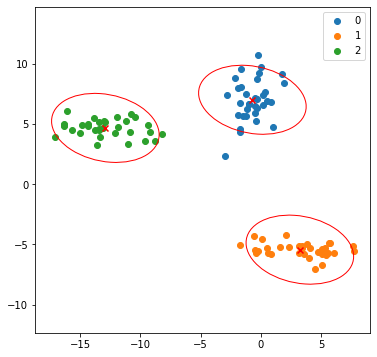

In [6]:
X, y, transformation = generate_data(N=100, K=3)
plot_data(X, y, transformation)

<div class="qst">

* Completa la clase `GMM` satisfaciendo los requisitos indicados anteriormente.

</div>

In [7]:
from sklearn.cluster import KMeans
import warnings

class GMM:
    """ 
        Sugerencia para la organización del código
    """
    
    def __init__(self, 
                n_components: int = 3, 
                n_iterations: int = 100, 
                tol: float = 1e-3,
                reg_covar: float = 1e-5,
                init_params: str = "kmeans"
    ):
        self.n_components = n_components
        self.n_iterations = n_iterations
        self.tol = tol
        self.reg_covar = reg_covar
        self.init_params = init_params        

    def _estimate_gaussian_parameters(self, X, resp):
        """ 
        Estimate the Gaussian distribution parameters.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input data array.
        resp : array-like of shape (n_samples, n_components)
            The responsibilities for each data sample in X.
        
        Returns
        -------
        priors : array-like of shape (n_components,)
            The priors of data samples in the current components.
        means : array-like of shape (n_components, n_features)
            The centers of the current components.
        covs : array-like of shape (n_components, n_features, n_features)
            The covariance matrix of the current components.
        """
        
        n_samples, n_features = X.shape
        
        priors = resp.sum(axis=0)
        
        means = resp.T @ X / priors[:, None]
        
        covs = np.empty((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            X_mean = X - means[k]
            covs[k] = resp[:, k] * X_mean.T @ X_mean / priors[k]
            # Add regularization term at the diagonal
            covs[k].flat[:: n_features + 1] += self.reg_covar
        
        priors /= n_samples
        
        return priors, means, covs
    
    def _compute_precision_cholesky(self):
        """
        Compute the Cholesky decomposition of the precision matrix, the inverse of covariance matrix.
        
        Returns
        -------
        precisions_cholesky : array-like of shape (n_components, n_features, n_features)
            The cholesky decomposition of sample precisions of the current
            components.
        """

        n_features = self.covs_.shape[1]
        precisions_cholesky = np.empty((self.n_components, n_features, n_features)) 
        for k in range(self.n_components):
            cov_chol = np.linalg.cholesky(self.covs_[k])
            precisions_cholesky[k] = scipy.linalg.solve_triangular(cov_chol,
                                                                   np.eye(n_features),
                                                                   lower=True).T 
        return precisions_cholesky
        
    
    def _initialize(self, X):
        """
        Initialization of the Gaussian mixture parameters.
            
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        
        """
        
        n_samples, _ = X.shape
        
        if self.init_params == "kmeans":
            resp = np.zeros((n_samples, self.n_components))
            labels = KMeans(n_clusters=self.n_components, n_init=1).fit(X).labels_
            resp[np.arange(n_samples), labels] = 1
        
        elif self.init_params == "random":
            resp = np.random.default_rng().random((n_samples, self.n_components))
            resp /= resp.sum(axis=1)[:, None]
        
        else:
            raise ValueError(f"Please, select 'kmeans' or 'random' init_param as initialization method.")
        
        self.priors_, self.means_, self.covs_ = self._estimate_gaussian_parameters(X, resp)        
        self.precisions_cholesky_ = self._compute_precision_cholesky()
        
    
    def _estimate_log_gaussian_prob(self, X):
        """
        Estimate the log Gaussian probability.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        
        Returns
        -------
        log_prob : array, shape (n_samples, n_components)
        """
        
        n_samples, n_features = X.shape
        
        log_prob = np.empty((n_samples, self.n_components))
        for k in range(self.n_components):
            log_prob[:, k] = np.sum(np.square((X - self.means_[k]) @ self.precisions_cholesky_[k]), axis=1)
            
        #  Compute the determinant of the precision matrix for each component
        log_det_chol = np.sum(
            np.log(self.precisions_cholesky_.reshape(self.n_components, -1)[:, :: n_features + 1]), 
            1
        )
        
        # Since we are using the precision of the Cholesky decomposition,
        # `- 0.5 * log_det_chol` becomes `+ log_det_chol`
        return -0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det_chol

    def _estimate_log_prob(self, X):
        """
        Estimate the log-probabilities, log P(X | Z) + log priors.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        
        Returns
        -------
        log_prob : array, shape (n_samples, n_component)
        """
        
        log_priors = np.log(self.priors_)
        log_gaussian_prob = self._estimate_log_gaussian_prob(X)
        
        return log_priors + log_gaussian_prob
           
    def _e_step(self, X):
        """
        E step.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        
        Returns
        -------
        log_prob_norm : float
            Mean of the logarithms of the probabilities of each sample in X
        log_responsibility : array, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        
        log_prob = self._estimate_log_prob(X)
        log_prob_norm = scipy.special.logsumexp(log_prob, axis=1)
        
        log_resp = log_prob - log_prob_norm[:, None]
        
        return np.mean(log_prob_norm), log_resp

    
    def _m_step(self, X, log_resp):
        """
        M step.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        
        log_resp : array-like of shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        
        self.priors_, self.means_, self.covs_ = self._estimate_gaussian_parameters(X, np.exp(log_resp))
        self.precisions_cholesky_ = self._compute_precision_cholesky()
        
    def fit(self, X):
        """
        Estimate model parameters with the EM algorithm.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
            
        Returns
        -------
        self : object
            The fitted mixture.
        """
        
        converged = False
        
        log_prob = -np.infty
        self.log_probs = []
        
        # Inicialización
        self._initialize(X)
        
        for _ in range(self.n_iterations):
            # Paso E
            current_log_prob, log_resp = self._e_step(X)
            self.log_probs.append(current_log_prob)
            
            # Paso M
            self._m_step(X, log_resp)
            
            # Check convergence criteria
            if abs(current_log_prob - log_prob) < self.tol:
                converged = True
                break
            
            log_prob = current_log_prob
            
        
        if converged == False:
            warnings.warn("EM method did not converge.")
            
        return self
        
    def predict(self, X):
        """
        Predict the labels for the data samples in X using trained model.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        
        _, log_resp = self._e_step(X)
        return log_resp.argmax(axis=1)
    
    def fit_predict(self, X):
        """
        Estimate model parameters using X and predict the labels for X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        
        return self.fit(X).predict(X)
        

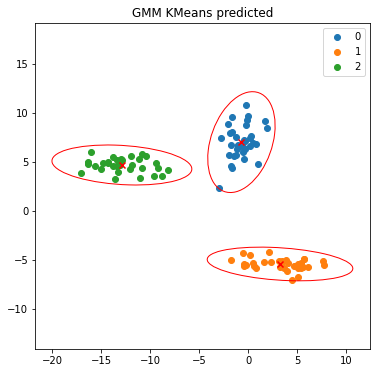

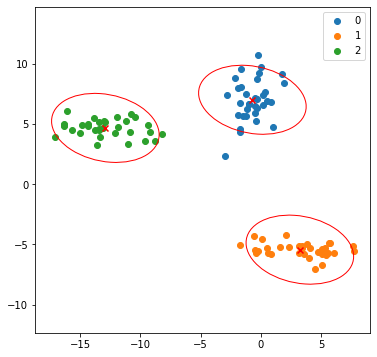

In [8]:
gmm = GMM(n_components=3, init_params="kmeans")        
pred = gmm.fit_predict(X)
plot_data(X, pred, means = gmm.means_, covs = gmm.covs_, title = "GMM KMeans predicted")
plot_data(X, y, transformation)

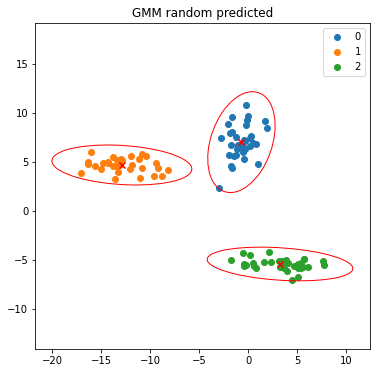

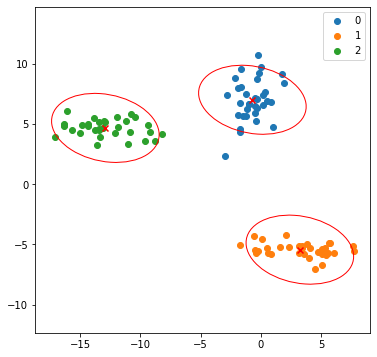

In [9]:
gmm = GMM(n_components=3, init_params="random")        
pred = gmm.fit_predict(X)
plot_data(X, pred, means = gmm.means_, covs = gmm.covs_, title = "GMM random predicted")
plot_data(X, y, transformation)

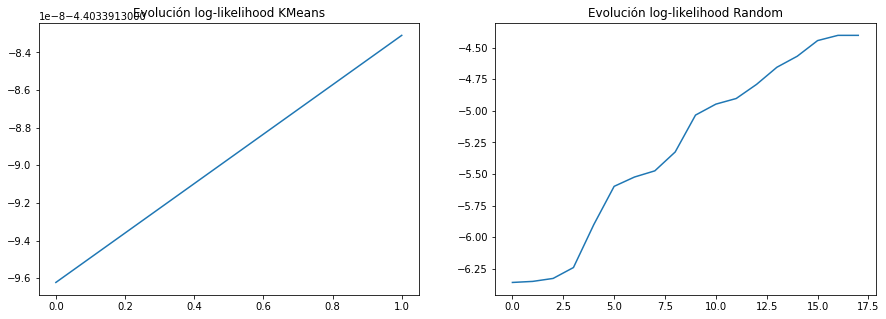

In [14]:
gmm = GMM(n_components=3, init_params="kmeans")        
gmm.fit(X)
gmm2 = GMM(n_components=3, init_params="random")        
gmm2.fit(X)

fig, axes = plt.subplots(1,2, figsize = (15,5))
axes[0].plot(gmm.log_probs)
axes[0].set_title("Evolución log-likelihood KMeans")
axes[1].plot(gmm2.log_probs)
axes[1].set_title("Evolución log-likelihood Random")
plt.show()

<div class="qst">

* Se deben **visualizar** los resultados obtenidos. Al menos se deben mostrar las covarianzas y medias finales estimadas (usando `make_ellipse`) y cómo ha evolucionado la log-verosimilitud de los datos.

</div>